In [1]:
!pip3 install seaborn
!pip3 install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 KB 154.5 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 39.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.0/322.0 KB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 35.2 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 41.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.9/106.9 KB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 45.5 MB/s eta 0:00:00a 0:00:01


In [18]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum as spark_sum, month, avg, count
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2
import os

In [3]:
class DBConfig:
    HOST = os.environ.get("DB_HOST", "localhost")
    PORT = os.environ.get("DB_PORT", "5432")
    DATABASE = os.environ.get("DB_NAME", "postgres")
    USER = os.environ.get("DB_USER", "postgres")
    PASSWORD = os.environ.get("DB_PASSWORD", "password")

    def get_url(self):
        """Create a connection URL to the PostgreSQL database."""
        return f"jdbc:postgresql://{self.HOST}:{self.PORT}/{self.DATABASE}"

    def get_conn(self):
        """Create a connection to the PostgreSQL database."""
        return psycopg2.connect(
            host=self.HOST,
            port=self.PORT,
            dbname=self.DATABASE,
            user=self.USER,
            password=self.PASSWORD,
        )

In [4]:
spark = SparkSession.builder.appName("FlightDelaysAnalysis").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/10/20 20:44:51 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


## Problématique :
Analyser les principales causes des retards aériens en fonction des différentes catégories (compagnie aérienne, météo, système national de l'air, sécurité, retard d'avion en correspondance) et visualiser leur répartition ainsi que leur évolution dans le temps.

In [12]:
def load_data():
    jdbc_url = DBConfig().get_url()
    properties = {
        "user": DBConfig.USER,
        "password": DBConfig.PASSWORD,
        "driver": "org.postgresql.Driver"
    }

    # Charger les données depuis PostgreSQL
    df = spark.read.jdbc(
        url=jdbc_url,
        table="on_time_performance",
        properties=properties
    )

    # Sélectionner les colonnes nécessaires et filtrer les retards non nuls
    df = df.filter(
            (col("CarrierDelay").isNotNull()) |
            (col("WeatherDelay").isNotNull()) |
            (col("NASDelay").isNotNull()) |
            (col("SecurityDelay").isNotNull()) |
            (col("LateAircraftDelay").isNotNull()) |
            (col("Cancelled").isNotNull())
        )
    return df

### 2. Analyse des retards par aéroport

In [20]:
def analyze_distance_delays(df):
    # Calculer la moyenne des retards en fonction de la distance
    distance_delays = df.groupBy("Distance").agg(
        avg("CarrierDelay").alias("AvgCarrierDelay"),
        avg("WeatherDelay").alias("AvgWeatherDelay"),
        avg("NASDelay").alias("AvgNASDelay"),
        avg("SecurityDelay").alias("AvgSecurityDelay"),
        avg("LateAircraftDelay").alias("AvgLateAircraftDelay")
    )
    
    # Convertir en Pandas pour visualisation
    distance_delays_pd = distance_delays.toPandas()
    distance_delays_pd = distance_delays_pd.sort_values("Distance")
    
    # Visualiser les retards en fonction de la distance
    plt.figure(figsize=(10, 6))
    sns.lineplot(x="Distance", y="AvgCarrierDelay", data=distance_delays_pd, label="Carrier Delay")
    sns.lineplot(x="Distance", y="AvgWeatherDelay", data=distance_delays_pd, label="Weather Delay")
    sns.lineplot(x="Distance", y="AvgNASDelay", data=distance_delays_pd, label="NAS Delay")
    sns.lineplot(x="Distance", y="AvgSecurityDelay", data=distance_delays_pd, label="Security Delay")
    sns.lineplot(x="Distance", y="AvgLateAircraftDelay", data=distance_delays_pd, label="Late Aircraft Delay")
    plt.title('Average Delay by Distance')
    plt.ylabel('Average Delay (Minutes)')
    plt.xlabel('Distance (Miles)')
    plt.legend(loc="upper right")
    plt.show()

### 2. Distribution des retards par heures de départ

In [21]:
def analyze_hourly_delays(df):
    # Convertir les heures au format 'hhmm' en un format lisible (hh:mm)
    df = df.withColumn("DepTimeHour", (col("DepTime") / 100).cast("int"))
    
    # Calculer la moyenne des retards par heure de départ
    hourly_delays = df.groupBy("DepTimeHour").agg(
        avg("CarrierDelay").alias("AvgCarrierDelay"),
        avg("WeatherDelay").alias("AvgWeatherDelay"),
        avg("NASDelay").alias("AvgNASDelay"),
        avg("SecurityDelay").alias("AvgSecurityDelay"),
        avg("LateAircraftDelay").alias("AvgLateAircraftDelay")
    )
    
    # Convertir en Pandas pour visualisation
    hourly_delays_pd = hourly_delays.toPandas()
    
    # Visualiser les retards par heure de départ
    plt.figure(figsize=(10, 6))
    sns.lineplot(x="DepTimeHour", y="AvgCarrierDelay", data=hourly_delays_pd, label="Carrier Delay")
    sns.lineplot(x="DepTimeHour", y="AvgWeatherDelay", data=hourly_delays_pd, label="Weather Delay")
    sns.lineplot(x="DepTimeHour", y="AvgNASDelay", data=hourly_delays_pd, label="NAS Delay")
    sns.lineplot(x="DepTimeHour", y="AvgSecurityDelay", data=hourly_delays_pd, label="Security Delay")
    sns.lineplot(x="DepTimeHour", y="AvgLateAircraftDelay", data=hourly_delays_pd, label="Late Aircraft Delay")
    plt.title('Average Delay by Departure Hour')
    plt.ylabel('Average Delay (Minutes)')
    plt.xlabel('Departure Hour (HH)')
    plt.legend(loc="upper right")
    plt.show()

In [22]:
def main():
    # Charger les données
    df = load_data()

    # Analyse des retards en fonction de la distance
    analyze_distance_delays(df)
    
    # Distribution des retards par heure de départ
    analyze_hourly_delays(df)

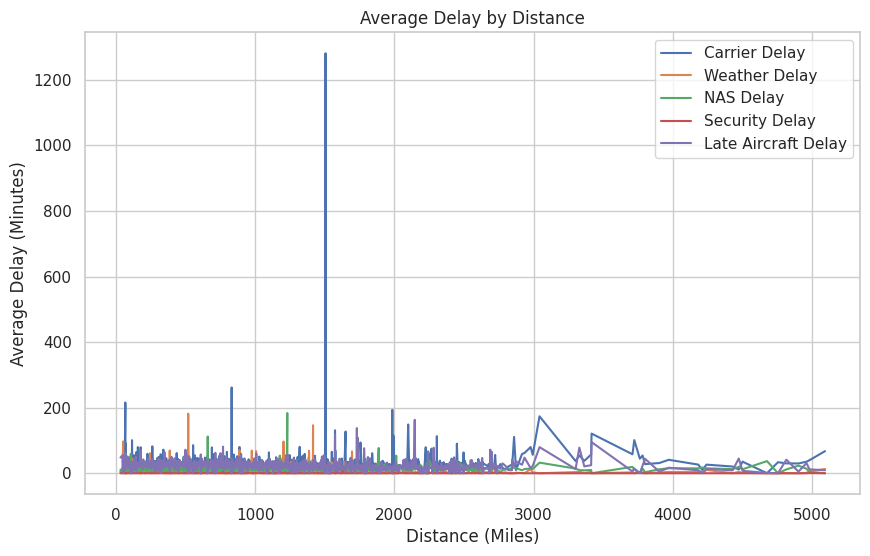

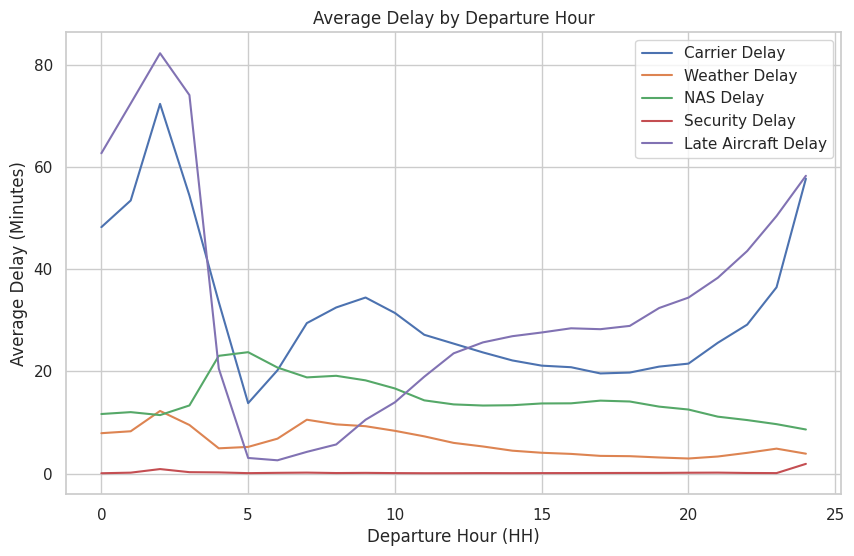

In [23]:
main()